# NeRF

### Reference

https://github.com/bmild/nerf/blob/master/tiny_nerf.ipynb

https://colab.research.google.com/drive/1rO8xo0TemN67d4mTpakrKrLp03b9bgCX

In [22]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm

## Dataset

- https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [23]:
if not os.path.exists("tiny_nerf_data.npz"):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz


In [24]:
dataset = np.load("tiny_nerf_data.npz")

print(dataset.files)
print(dataset["images"].shape)

# Extrinsic parameters
# eye_coordinate -> world_coordinate
print(dataset["poses"].shape)

# Intrinsic parameters (focal length)
print(dataset["focal"])

['images', 'poses', 'focal']
(106, 100, 100, 3)
(106, 4, 4)
138.88887889922103


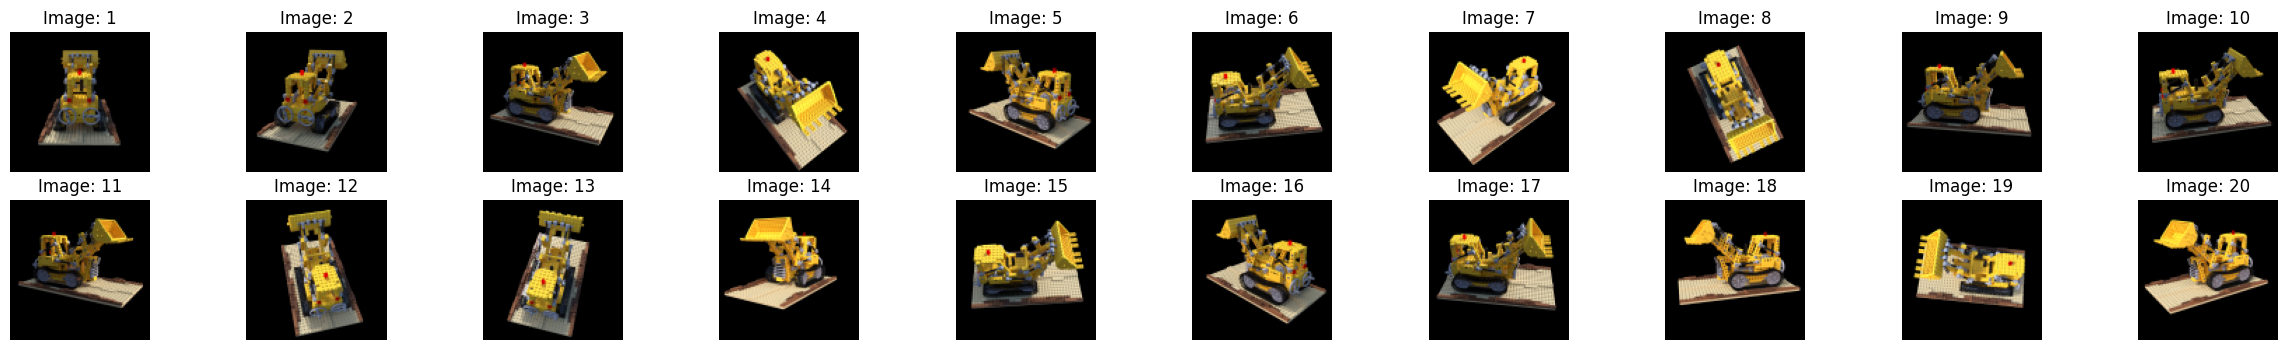

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(30, 4))

for idx, ax in enumerate(axs.flatten()):
  plt.sca(ax)
  plt.imshow(dataset["images"][idx])
  plt.title("Image: {}".format(idx + 1))
  plt.axis("off")

In [26]:
poses = dataset["poses"]
print(poses[:5, ...])
print(poses.shape)
# Extrinsic parameters given as 4x4 matrix

[[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
  [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
  [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[-9.3054223e-01  1.1707554e-01 -3.4696460e-01 -1.3986591e+00]
  [-3.6618456e-01 -2.9751042e-01  8.8170075e-01  3.5542498e+00]
  [ 7.4505806e-09  9.4751304e-01  3.1971723e-01  1.2888215e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 4.4296363e-01  3.1377721e-01 -8.3983749e-01 -3.3854935e+00]
  [-8.9653969e-01  1.5503149e-01 -4.1494811e-01 -1.6727095e+00]
  [ 0.0000000e+00  9.3675458e-01  3.4998694e-01  1.4108427e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 7.9563183e-01  5.2092606e-01 -3.0920234e-01 -1.2464346e+00]
  [-6.0578054e-01  6.8418401e-01 -4.0610620e-01 -1.6370665e+00]
  [-1.4901161e-08  5.1041979e-01  8.5992539e-01  3.4664700e+00]
  [ 0.0000000e+00  0.0000000e+00  

### Viewing Direction
#### Method 1

In [27]:
# Change viewing direction vector from eye coordinates to world coordinates
# Transform a vector with rigid transformation matrix

v_dir = np.array([[0], [0], [-1]])

world_coordinate_v_dir = np.stack([np.matmul(pose[:3, :3], v_dir).squeeze() for pose in poses])
print(world_coordinate_v_dir[:5, ...])
print(world_coordinate_v_dir.shape)

[[ 0.01334572 -0.95394367 -0.29968831]
 [ 0.3469646  -0.88170075 -0.31971723]
 [ 0.83983749  0.41494811 -0.34998694]
 [ 0.30920234  0.4061062  -0.85992539]
 [-0.71605819 -0.62345237 -0.31395501]]
(106, 3)


#### Method 2

In [28]:
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])

print(dirs[:5, ...])
print(dirs.shape)

[[ 0.01334572 -0.95394367 -0.29968831]
 [ 0.3469646  -0.88170075 -0.31971723]
 [ 0.83983749  0.41494811 -0.34998694]
 [ 0.30920234  0.4061062  -0.85992539]
 [-0.71605819 -0.62345237 -0.31395501]]
(106, 3)


### Camera Positions

In [29]:
positions = poses[:, :3, 3]
print(positions[:5, ...])
print(positions.shape)

[[-0.05379832  3.8454704   1.2080823 ]
 [-1.3986591   3.5542498   1.2888215 ]
 [-3.3854935  -1.6727095   1.4108427 ]
 [-1.2464346  -1.6370665   3.46647   ]
 [ 2.886523    2.513217    1.2655932 ]]
(106, 3)


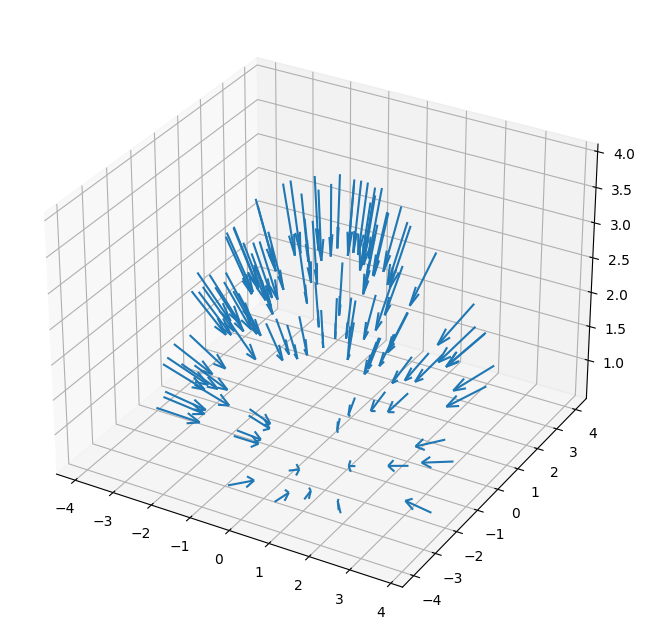

In [30]:
ax = plt.figure(figsize=(12,8)).add_subplot(projection="3d")

_ = ax.quiver(
    positions[..., 0],
    positions[..., 1],
    positions[..., 2],
    dirs[..., 0],
    dirs[..., 1],
    dirs[..., 2]
)

## Utilities

### `get_rays`

In [31]:
def get_rays(h:int, w:int, focal_length:float, pose:torch.Tensor):
  i, j = torch.meshgrid(
      torch.arange(w, dtype=torch.float32).to(pose),
      torch.arange(h, dtype=torch.float32).to(pose),
      indexing="ij"
  )

  i = i.transpose(-1, -2)
  j = j.transpose(-1, -2)

  rays_d = torch.stack([
      (i - w * 0.5) / focal_length,
      (j - h * 0.5) / focal_length,
      -torch.ones_like(i)
  ], dim = -1)

  # shape of rays_d: (width, height, 3)
  # method 1
  rays_d = torch.sum(rays_d[..., np.newaxis, :] * pose[:3,:3], dim=-1)

  # method 2
  #rays_d = torch.matmul(pose, rays_d[..., None]).squeeze(-1)

  rays_o = pose[:3,-1].expand(rays_d.shape)

  return rays_o, rays_d

#### How does `torch.meshgrid` work?

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F2g4hj%2Fbtr6GU8DlGZ%2F89I9rdWT5wVwRjcdVAJKdk%2Fimg.jpg"></img>

In [32]:
width = 10
height = 20
focal_length = 10

i, j = torch.meshgrid(
    torch.arange(width, dtype=torch.float32),
    torch.arange(height, dtype=torch.float32),
    indexing="ij"
)


i = i.transpose(-1, -2)
j = j.transpose(-1, -2)


rays_d = torch.stack([
  (i - width * 0.5) / focal_length,
  (j - height * 0.5) / focal_length,
  -torch.ones_like(i)
], dim = -1)

print(rays_d.shape)

# print('---Rays_d 1---')
# print(rays_d[..., np.newaxis, :])
# print('---Rays_d 2---')
# print(rays_d[..., np.newaxis, :] * poses[0, :3,:3])
# print('---Rays_d 3---')
# print(torch.sum(rays_d[..., np.newaxis, :] * poses[0, :3,:3], dim=-1))

torch.Size([20, 10, 3])


In [33]:
width = 10
height = 20
focal_length = 10

i, j = torch.meshgrid(
    torch.arange(width, dtype=torch.float32),
    torch.arange(height, dtype=torch.float32),
    indexing="ij"
)


i = i.transpose(-1, -2)
j = j.transpose(-1, -2)


rays_d = torch.stack([
  (i - width * 0.5) / focal_length,
  (j - height * 0.5) / focal_length,
  -torch.ones_like(i)
], dim = -1)


# shape of rays_d: (width, height, 3) => (width, height, 3, 1)
# shape of pose: (3, 3)

pose = torch.Tensor(poses[0, :3, :3])
w_rays_d = torch.matmul(pose, rays_d[..., None]).squeeze(-1)

print(pose.shape)
print(w_rays_d.shape)
print(w_rays_d[:5, ...])

torch.Size([3, 3])
torch.Size([20, 10, 3])
tensor([[[ 0.5091, -0.6473, -1.2537],
         [ 0.4091, -0.6487, -1.2537],
         [ 0.3091, -0.6501, -1.2537],
         [ 0.2091, -0.6515, -1.2537],
         [ 0.1091, -0.6529, -1.2537],
         [ 0.0092, -0.6543, -1.2537],
         [-0.0908, -0.6557, -1.2537],
         [-0.1908, -0.6571, -1.2537],
         [-0.2908, -0.6585, -1.2537],
         [-0.3908, -0.6599, -1.2537]],

        [[ 0.5095, -0.6773, -1.1583],
         [ 0.4095, -0.6787, -1.1583],
         [ 0.3095, -0.6801, -1.1583],
         [ 0.2096, -0.6815, -1.1583],
         [ 0.1096, -0.6829, -1.1583],
         [ 0.0096, -0.6843, -1.1583],
         [-0.0904, -0.6856, -1.1583],
         [-0.1904, -0.6870, -1.1583],
         [-0.2904, -0.6884, -1.1583],
         [-0.3904, -0.6898, -1.1583]],

        [[ 0.5099, -0.7072, -1.0629],
         [ 0.4100, -0.7086, -1.0629],
         [ 0.3100, -0.7100, -1.0629],
         [ 0.2100, -0.7114, -1.0629],
         [ 0.1100, -0.7128, -1.0629],
   

In [34]:
def stratified_sampling(rays_o, rays_d, near, far, n):
  '''
  shape
    rays_o: (width, height, 3)
    rays_d: (width, height, 3)
  '''

  t = torch.linspace(near, far, n).to(rays_o)

  # noise_shape: (width, height, n)
  noise_shape = list(rays_o.shape[:-1]) + [n]

  # shape of t: (width, height, n)
  t = torch.rand(noise_shape).to(rays_o) * (far - near) / n + t
  
  # shape of x: (width, height, num_samples, 3)
  x = rays_o[..., None,:] + rays_d[..., None,:] * t[..., :, None]
  
  return x, t

### Positional Encoding

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FkK56S%2FbtrXJqmpliA%2F16eSKlkgKRdAv36FGlpTL1%2Fimg.png"></img>

In [35]:
def positional_encoding(x, L=6, include_input=True):
  encoding = [x] if include_input else[]

  frequency_bands = 2.0 ** torch.linspace(
      0.0, L-1, L, dtype=x.dtype, device=x.device,
  )

  for freq in frequency_bands:
    encoding.append(torch.sin(x * freq * np.pi))
    encoding.append(torch.cos(x * freq * np.pi))

  return torch.cat(encoding, dim=-1)

### Volumetric Rendering

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbu2QAn%2FbtrXHIBmTxw%2FYy9WOJf3EhVQyKXblRpFk1%2Fimg.jpg"></img>

In [36]:
def volumetric_rendering(c, sigma, rays_o, t):
  # shape of sigma: (width, height, 1)
  sigma = F.relu(sigma)[..., 0]

  c = torch.sigmoid(c)

  # Distance between adjacent points
  # shape of delta: (width, height, n-1)
  delta = t[..., 1:] - t[..., :-1]

  # At the end of the ray, the distance is really large.
  # (width, height, n-1) + (width, height, 1) => (width, height, n)
  delta = torch.cat([
      delta, torch.tensor([1e10], dtype=rays_o.dtype, device=rays_o.device).expand(t[...,:1].shape)
  ], dim=-1)

  # alpha is a transparency on t (not transparent if alpha is large)
  # shape of alpha: (width, height, n)
  alpha = 1. - torch.exp(-sigma * delta)
  
  # T is a transmittance to t
  T = torch.cumprod(1. -alpha + 1e-10, -1)
  # Elements in the last dimension are shifted to the right.
  T = torch.roll(T, 1, -1)
  T[..., 0] = 1.

  # shape of w: (width, height, n)
  w = T * alpha

  # Integrate colors of sample points on the ray.
  # shape of rgb: (width, height, n, 3) => (width, height, 3)
  rgb = (w[..., None] * c).sum(dim=-2)

  return rgb

## Model

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbVRyDn%2FbtrXCH4LXLN%2Fg04M7gNMjbPMMtwtMPymCk%2Fimg.png"></img>

In [37]:
class NeRF(torch.nn.Module):
  def __init__(self, gamma_x_dim=60, gamma_d_dim=24, num_channels=256, num_layers=8, skip=4):
    super(NeRF, self).__init__()

    self.layers = []
    self.skip = skip

    for i in range(num_layers):
      if not i == skip:
        if i == 0:
          self.layers.append(torch.nn.Linear(gamma_x_dim, num_channels))
        else:
          self.layers.append(torch.nn.Linear(num_channels, num_channels))
      else:
        self.layers.append(torch.nn.Linear(num_channels + gamma_x_dim, num_channels))

    self.layers = torch.nn.ModuleList(self.layers)
    self.sigma_out = torch.nn.Linear(num_channels, 1)
    
    self.feature = torch.nn.Linear(num_channels, num_channels)
    self.branch = torch.nn.Linear(num_channels + gamma_d_dim, num_channels // 2)
    self.rgb_out = torch.nn.Linear(num_channels // 2, 3)

    self.relu = torch.nn.functional.relu


  def forward(self, x, d):
    out = x

    for idx, layer in enumerate(self.layers):
      if not idx == self.skip:
        out = self.relu(self.layers[idx](out))
      else:
        out = torch.cat([out, x], dim=-1)
        out = self.relu(self.layers[idx](out))

    sigma = self.sigma_out(out)

    out = self.feature(out)
    out = self.relu(self.branch(torch.cat([out, d], dim=-1)))
    color = self.rgb_out(out)

    return color, sigma

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images = dataset["images"]
poses = dataset["poses"]
focal_length = dataset["focal"]

num_images, h, w = images.shape[:3]

print("num_images: ", num_images)
print("h: ", h)
print("w:", w)

test_idx = 101
test_image = images[test_idx]
test_pose = poses[test_idx]

images = torch.from_numpy(images[:100, ..., :3]).to(device)
poses = torch.from_numpy(poses).to(device)
focal_length = torch.from_numpy(focal_length).to(device)

num_images:  106
h:  100
w: 100


## Settings

In [39]:
L_x = 10
L_d = 4

Num_samples = 64

lr = 5e-4
num_iters = 1000
num_channels = 128
num_layers = 8
skip = 4

display_every_iter = 100
near = 2.
far = 6.

batch_size = 4 * 1024
include_input = False

In [40]:
gamma_x_dim = L_x * 2 * 3 + (3 if include_input else 0)
gamma_d_dim = L_d * 2 * 3 + (3 if include_input else 0)

model = NeRF(gamma_x_dim, gamma_d_dim, num_channels, num_layers, skip)
model = model.to(device)

## Training

In [41]:
def train_step(h, w, focal_length, pose, near, far, num_samples, L_x, L_d):
  rays_o, rays_d = get_rays(h, w, focal_length, pose)
  
  x, t = stratified_sampling(rays_o, rays_d, near, far, num_samples)

  # (width, height, 3) => (width * height, 3)
  x_flatten = x.reshape(-1, 3)
  d_flatten = rays_d[..., None, :].expand_as(x).reshape(-1, 3)
  
  gamma_x = positional_encoding(x_flatten, L_x, include_input=include_input)
  gamma_d = positional_encoding(d_flatten, L_d, include_input=include_input)

  pred = []

  for i in range(0, gamma_x.shape[0], batch_size):
    pred.append(model(gamma_x[i:i+batch_size], gamma_d[i:i+batch_size]))
  
  colors = torch.concat([p[0] for p in pred], dim=0).reshape(h, w, -1, 3)
  sigma = torch.concat([p[1] for p in pred], dim=0).reshape(h, w, -1, 1)

  rgb = volumetric_rendering(colors, sigma, rays_o, t)
  return rgb

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

progress_bar = tqdm(range(num_iters))

for i in progress_bar:
  idx = np.random.randint(images.shape[0])
  images_i = images[idx]
  pose_i = poses[idx]

  rgb_predicted = train_step(h, w, focal_length, pose_i, near, far, Num_samples, L_x, L_d)

  loss = F.mse_loss(rgb_predicted, images_i)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  progress_bar.set_postfix({"loss": loss.item()})
  
  if i % display_every_iter == 0:
    rgb_predicted = train_step(h, w, focal_length, torch.from_numpy(test_pose).to(device), near, far, Num_samples, L_x, L_d)

    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())

    plt.subplot(122)
    plt.imshow(test_image)
    plt.title(f"Iteration{i}")
    plt.show()